In [1]:
# Please execute this cell (shift+<Return>) before starting the workbook
# this should print out "Your notebook is ready to go"
from IPython.display import HTML, SVG, display
import os
import sys
from IPython.display import HTML, SVG, display
sys.path.append(os.path.abspath('genealogy_workshop'))

import genealogical_analysis_workshop

workbook = genealogical_analysis_workshop.setup_workbook2()
display(HTML(workbook.css))
print("Your notebook is ready to go")

Your notebook is ready to go


# Simulating ancestry with msprime

We will use `msprime`, a backwards-time tree sequence simulator, to generate genealogical trees with mutations occurring along them. We will simulate genomic data sets using two demographic models: (1) a simple model with a single, panmictic population and (2) a stepping stone model with nine populations. `msprime ` can simulate data under more complicated demographic models, but this is not part of this workbook (see the end of this notebook for links and tutorials).
 
### Why do we do simulations in population genetics?

**Exploration:**
Simulations allow us to explore the influence of various historical scenarios on observed patterns of genetic variation and inheritance.

**Benchmarking and evaluating methodologies:**
To assess the accuracy of inferential methods, we need test datasets for which the true values of important parameters are known.

**Model training:**
Some methods for ancestry inference are trained on simulated data (e.g., Approximate Bayesian Computation).
This is especially important in studies of complex demographies, where there are many potential parameters and models, making it impractical to specify likelihood functions.

### A brief history of msprime

The first release of `msprime` was an emulation of the popular `ms` coalescent simulator with added support for tree sequences.
However, it has since become an expansive and flexible backwards-in-time simulator for various different models of genetic ancestry and mutation, and even for simplified models of selection.
There is a *forwards-time* simulator named `SLiM` which is not covered in this workshop.
Furthermore, it is possible to combine *backwards-time* and *forwards-time* simulations from `msprime` and `SLiM`.

### Backwards simulation

The main characteristic of `msprime` is that is simulates *tree sequences* in *backwards-time*.

<img src="pics/msprime-1.png" style="display:inline-block" width="190" height="190">
<img src="pics/msprime-2.png" style="display:inline-block" width="190" height="190">
<img src="pics/msprime-3.png" style="display:inline-block" width="190" height="190">
<img src="pics/msprime-4.png" style="display:inline-block" width="190" height="190">
<img src="pics/msprime-5.png" style="display:inline-block" width="190" height="190">

In [2]:
# Import all the required libraries at the start

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG

import msprime
import tskit
import tsinfer
import tsdate
import demesdraw

## Simulating a tree sequence

To perform simulations using `msprime`, we first simulate a tree sequence without mutations (i.e. the genetic genealogy) using `sim_ancestry()`. If desired, we then add neutral mutations to the tree sequence using `sim_mutations()`.

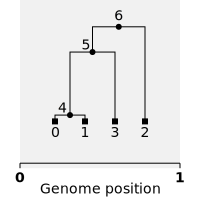

In [3]:
ts = msprime.sim_ancestry(
    samples=2, # Two diploid individuals
    random_seed=1
)
SVG(ts.draw_svg())

In [4]:
ts # Note there are no mutations yet

## Specifying information about sample genomes
Although we have specified 2 samples, our tree sequence contains 4 sample nodes (i.e. sample genomes).
This is because the `samples` argument specifies the number of *individuals* in the sample,
and by default, `sim_ancestry()` assumes diploid organisms.
To change this, use the `ploidy` argument:

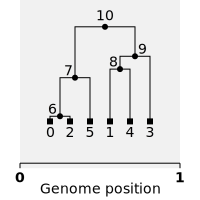

In [5]:
ts = msprime.sim_ancestry(
    samples=2,
    ploidy=3, # Two triploid individuals
    random_seed=1
)
SVG(ts.draw_svg())

It's easiest to start thinking about genome lengths in units of nucleotides. By default, we are simulating a sequence length that spans just one of these units.
We can specify a larger region using the `sequence_length` argument:

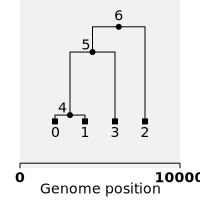

In [6]:
ts = msprime.sim_ancestry(
    samples=2,
    sequence_length=1e4, # 10 Kb
    random_seed=1
)
SVG(ts.draw_svg())

Also, note that our 'tree sequence' consists of just a single tree. This is because we have not yet specified a `recombination_rate`, which is set to 0 by default. 
This is the probability of a recombination event per genomic unit (base), per generation.

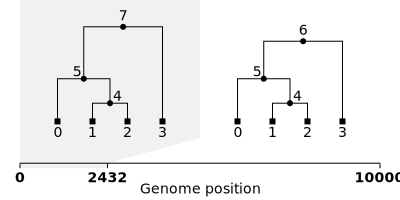

In [7]:
ts = msprime.sim_ancestry(
    samples=2,
    sequence_length=1e4,
    recombination_rate=1e-5, # Allow for recombination: this is quite a high rate
    random_seed=100
)
SVG(ts.draw_svg())

## Basic population information

Finally, we need to say something about the dynamics of the wider population from which our samples have been drawn. The default is to assume a single randomly mating population of fixed size (later we will see how to change this). In a simple model like this, most users will therefore want to specify a `population_size`. Population geneticists sometimes refer to this as $N_e$, or the "effective population size" in a panmictic population.

<div class="alert alert-block alert-info"><b>Note:</b>
The standard <code>msprime</code> model is a theoretical one that allows the population size to be any floating point number greater than 0. In fact, if not specified, the population size in msprime defaults to 1, which sounds biologically impossible, but simply produces a result identical to that of a large population, but with the time units scaled differently.
</div>

In [8]:
ts_small = msprime.sim_ancestry(
    samples=2,
    sequence_length=1e3, # Small 1Kb region
    recombination_rate=1e-8, # Small recombination rate
    population_size=20_000, # Rough "effective population size" suitable for humans
    random_seed=107
)
ts_small  # Display summary to screen

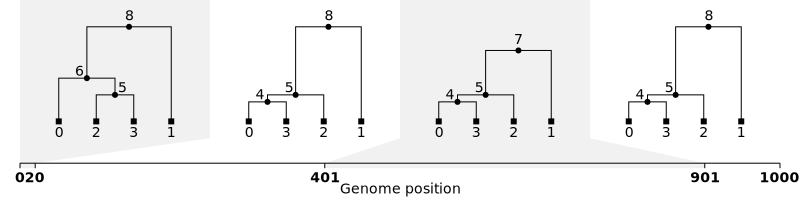

In [9]:
display(SVG(ts_small.draw_svg()))

<dl><dt>Exercise 1</dt><dd>To illustate the speed of <code>msprime</code>, simulate a large tree sequence of 20,000 diploid individuals, each with a 1 Mbp long genome, using a recombination rate of 1e-8 from a population of size 20,000. Run the simulation with a random seed of 2022,  save it to the variable `ts`, and output the summary table on the screen.
<div class="alert alert-block alert-info"><b>Tip:</b>
    Make sure you DON'T display the SVG trees! Each tree is huge, and there are a lot of them.</div></dd></dl>

In [10]:
# Exercise 1: set `ts` to a new large tree sequence, generated using msprime.sim_ancestry() with
# specific parameters (random_seed=2022, etc.), then output the tree sequence summary table to screen


In [11]:
workbook.Q1()

## Simulating mutations along the tree sequence

Next, to generate genetic variation, we add mutations by applying `sim_mutations()` to the existing `TreeSequence` object. At minimum, you must supply a per-base, per-generation mutation rate.

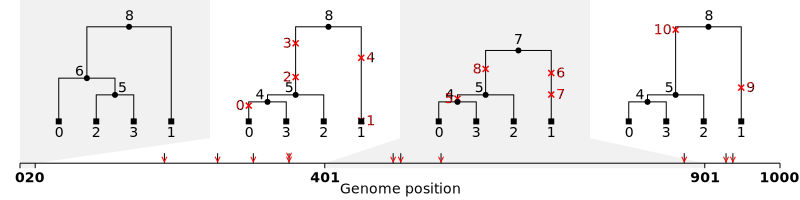

In [12]:
mts_small = msprime.sim_mutations(
    ts_small, # Use the small tree sequence so that we can plot it easily
    rate=2e-7, # Set an unusually high mutation rate per generation per base pair
    random_seed=103
)
SVG(mts_small.draw_svg())

In [13]:
mts_small # Note there are 10 sites with variation but 11 mutations

<dl><dt>Exercise 2</dt><dd>Print out the mutation tables for the <code>mts_small</code> tree sequence</dd></dl>

In [14]:
# Exercise 2: print out the mutations table. Notice that one site has experienced multiple mutations.


In [15]:
workbook.Q2()

Adding mutations to a tree sequence is usually very fast, and the resulting tree sequence is a highly efficient way of storing genomic data. For instance, adding 10,000 sites to the large tree sequence you simulated in Exercise 1 should take less than a second, and corresponds to a storing a sites-by-samples matrix of 40,000 by 10,000 vlaues (i.e. 400 million genotypes). In tree sequence format, this only takes up about 8Mb of space. The equivalent VCF would be thousands or tens of thousands of times larger.

<dl><dt>Exercise 3</dt><dd>Add mutations to the large tree sequence generated in Exercise 1 using a mutation rate of 1e-8. Run the simulation using a random seed of 2022, and print a summary table of the resuling tree sequence to the screen</dd></dl>

In [16]:
# Exercise 3: Add lots of mutations to the huge genealogy you simulated earlier


In [17]:
workbook.Q3()

## More complicated simulations
 - **Recombination rate variation across the genome** We can introduce this by creating a `RateMap` object, which lists recombination rates between defined positions in the sequence.
```
recomb_rate_map = msprime.RateMap(position=[0, 10, 20], rate=[0.01, 0.1])
ts = msprime.sim_ancestry(3, recombination_rate=recomb_rate_map, random_seed=2)
SVG(ts.draw_svg())
```
 - **Mutation rate variation across the genome** This can also be introduced using a `RateMap` object, which lists mutation rates between defined position in the sequence.
```
mutation_rate_map = msprime.RateMap(position=[0, 40, 60, 100], rate=[0.01, 0.1, 0.01])
mts = msprime.sim_mutations(ts, rate=mutation_rate_map, random_seed=104)
SVG(mts.draw_svg())
```
 - **Mutation models** There are pre-defined models (e.g., Jukes-Cantor). You can also use your own custom models.
 - **Stacking mutations** Mutations can be simulated on the same tree sequence under different models and/or parameters and/or over different time periods.
 - **Continuous coordinates** By default, the recombination and mutation events will be assigned to integer locations along the sequence. However, there may be situations where you want to model the genome using continuous coordinates. In this case, use the `discrete_genome=False` argument:
```
ts = msprime.sim_ancestry(
    samples=2,
    random_seed=28,
    sequence_length=100,
    recombination_rate=0.01,
    discrete_genome=False
)
SVG(ts.draw_svg())
```
 - **Gene conversion** See the API documentation for the `gene_conversion_rate` and `gene_conversion_tract_length` arguments, and [this](https://tskit.dev/msprime/docs/stable/ancestry.html?highlight=gene%20conversion#gene-conversion) short illustration of use.

## Simulations under custom demographic models

To simulate under more complicated models of demographic history, we need to create a `msprime.Demography` object.

`msprime` supports simulation from multiple discrete populations, sometime called "demes". It provides a number of [built-in theoretical models](https://tskit.dev/msprime/docs/stable/demography.html#quick-reference), and a [library of community-validated demographic models](https://elifesciences.org/articles/54967) for a number of common species, including humans, is available in the [stdpopsim](https://popsim-consortium.github.io/stdpopsim-docs/stable/tutorial.html#running-stdpopsim-with-the-python-interface-api) package. Alternatively you can create your own bespoke model, or modify an existing one, by adding populations to a demography using the `.add_population()` method of the demography object (for each population, you can specify a name, a sample size, an effective population size, and a growth rate to allow population size to change over time).

Let's simulate some data using the built-in stepping stone model, specifying eight populations. First, we create the demography object:

In [18]:
deme_size = 500 # population size of each deme
num_demes = 8
num_deme_samples = 40

demography = msprime.Demography.stepping_stone_model(
    [deme_size] * num_demes,
    migration_rate=0.05
)

To visualise this, the easiest thing is to convert it to the `demes` format, which we can then draw using the rather nifty `demesdraw` package. This plots the population size (on the x-axis) against time (on the y-axis)

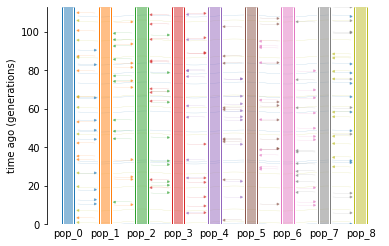

In [19]:
graph = msprime.Demography.to_demes(demography) # For visualization only

positions = {f"pop_{i}": i * deme_size * 3 for i in range(num_demes)}

fig, ax = plt.subplots() # Use plt.rcParams["figure.figsize"]
demesdraw.tubes(graph,
                ax=ax,
                positions=positions,
                seed=3)
plt.show()

Since all 8 populations are of constant size, they appear as fixed width "tubes" through time. You can see that each has a small amount of migration (arrows) from each population to the two adjacent ones. Here's how to actually simulate this demographic setup.
<div class="alert alert-block alert-info"><b>Note:</b>
    Because of limited migration, we expect the closest relatives of an individual to be found in the same population. As for the other populations, if you look carefully at the coloured arrows, you will see that the first and last population can migrate between each other, so the populations can actually be thought of as lying on a circle. All other things being equal, from the point of view of an individual in `pop_0`, on average `pop_1` and `pop_7` should contain the next closest relatives, then `pop_2` and `pop_6`, then `pop_3` and `pop_4`; finally, `pop_5` should contain, on average, the most distant relatives.</div>

In [20]:
ts = msprime.sim_ancestry(
    {population_id: num_deme_samples for population_id in range(num_demes)},
    sequence_length=2e6, # 2Mb
    demography=demography,
    recombination_rate=1e-8, # Human-like recombination rate
    random_seed=3,
)

mts = msprime.sim_mutations(
    ts,
    rate=1e-8, # Human-like mutation rate
    random_seed=3
)
mts # display it to screen: it should have 9 populations

Let's check the Fst statistics between (say) populations 0 and 1

In [21]:
pop_0_sample_ids = mts.samples(population=0)
pop_1_sample_ids = mts.samples(population=1)

print(
    "Fst from variable sites:",
    mts.Fst([pop_0_sample_ids, pop_1_sample_ids]),
    "\nFst from genealogical branch lengths:",
    mts.Fst([pop_0_sample_ids, pop_1_sample_ids], mode="branch")
)

Fst from variable sites: 0.001057649805427885 
Fst from genealogical branch lengths: 0.0005862377244109096


<dl><dt>Exercise 4</dt><dd>Using a <code>for</code> loop, print out the standard site-based $F_st$ values between samples in population 0 and samples from each of the other 8 populations in turn. Does $F_st$ reflect the expected relationship between populations?</dd></dl>

In [22]:
workbook.Q4()

## Running the same simulation many times
Variation among simulated genetic genealogies means that there is variation in branch-wise statistics among the genealogies as well. To see this, we need a bunch of simuation replicates. The `num_replicates` argument in `sim_ancestry()` offers a convenient way to run many simulations under the same model. Here we calculate the Fst between two adjacent populations in our stepping stone model:

In [23]:
Fst_vals = []

for ts in msprime.sim_ancestry(
    {i: num_deme_samples for i in range(num_demes)},
    sequence_length=1e6,
    demography=demography,
    recombination_rate=1e-8,
    random_seed=1234,
    num_replicates=100
):
    Fst = ts.Fst([ts.samples(0), ts.samples(1)], mode="branch")
    Fst_vals.append(float(Fst))  # for convenience, convert the numpy array returned by ts.Fst to a standard number

<dl><dt>Exercise 5</dt><dd>Use <code>plt.hist()</code> to plot the histogram of Fst values, and <code>np.mean()</code> to print out the mean</dd></dl>

In [24]:
# Exercise 5: plot a histogram of Fst values: 


In [25]:
workbook.Q5()

## More complicated demographic models
 - Varying population size.
 - Population structure (multiple demes with different migration rates).
 - Migration (constant or varying migration rates).
 - Admixture.
 - Population divergence.

## Other topics of interest
 - Forward simulations using `SLiM` (and recapitation, which combines backwards-time and forwards-time simulations).
 - Combining demographic models in a single simulation.
 - Simple selective sweeps (e.g. genic selection).
 - Debugging demographic models (printing out all the information for checking).

# Inference using `tsinfer` and `tsdate`

Simulating genetic genealogies is relatively simple compared to inferring them from existing genetic data. Several software packages infer genetic genealogies which can be stored in tree sequence format, but by far the most scalable ones are [tsinfer](https://github.com/tskit-dev/tsinfer) and [tsdate](https://github.com/tskit-dev/tsdate).

## Inferring topology using `tsinfer`

`Tsinfer` (pronounced t-s-infer) is comparable in some ways to other ancestral inference software such as [ARGweaver](https://doi.org/10.1371/journal.pgen.1004342), [Relate](https://myersgroup.github.io/relate/) (which we will encounter this afternoon), and [Rent+](https://doi.org/10.1093/bioinformatics/btw735). However, it differs considerably in approach and scalability. Note that none of these other software packages produce their output in tree sequence (`tskit`) format, although is possible to convert their output to tree sequences. Also note that although `tsinfer` produces trees with a relatively accurate topology, but unlike other ancestral inference tools, it makes no attempt to produce branch length estimates -- for this we need another tool like `tsdate`.

The most important restrictions of `tsinfer` are:
1. It requires phased sample sequences
2. It only uses variants which have known ancestral states (other variants can be included, but do not contribute to the quality of inference)
3. It also works better with full sequence data than with data from scattered target SNPs (e.g. as obtained from SNP chips).

Inferences of large datasets (whole genomes from tens of thousands or samples or more) can take many days of computer time. For this reason, we will use a relatively small dataset: the genetic data that we simulated above using `msprime`. This generated 2Mb of genome (two and a half thousand sites) from 360 individuals (720 diploid genomes). A benefit of using a simulated dataset is that we can estimate how good out inference is.

Even though it is a small dataset, it would take hours or days to run using many other inference packages. Tsinfer should be able to do this in a few seconds.

### Input

`Tsinfer` requires a [SampleData](https://tsinfer.readthedocs.io/en/latest/api.html#sample-data) object as input. There are <a href="https://tsinfer.readthedocs.io/en/latest/tutorial.html#data-example">examples online</a> for how to create a SampleData file from the standard VCF format. To save time in this workbook, instead of reading in from a VCF file, we will use a built-in shortcut that creates a SampleData instance from an existing tree sequence with mutations. 

In [33]:
sample_data = tsinfer.SampleData.from_tree_sequence(mts)  # Normally you would probably create this from a VCF file

Now that we have the genetic variation data in SampleData format (phased haplotypes with known ancestral states), we can actually perform the inference. This may take a few tens of seconds to run.

<div class="alert alert-block alert-info"><b>Note:</b>
    For larger inferences, we recommend running <code>tsinfer</code> from the command-line rather than within the Python shell. To speed up inference, ot is also possible to run it on a large number of computer processors in parallel</div>

In [35]:
# This may take a few tens of seconds
inferred_ts = tsinfer.infer(sample_data)

The inferred ts should be identical to the original (this is lossless compression), and contains a single heuristic estimate of the genealogy.

Stuff here about the inferred ts needing to be dated....

In [ ]:
# This may take a few tens of seconds
dated_ts = tsdate.date(
    tsdate.preprocess_ts(inferred_ts),
    mutation_rate=1e-8,
    Ne=6_000,
    ignore_oldest_root=True
)

Note that branch-wise statistics differ noticeably between the *simulated* tree sequence and the *inferred* and *dated* tree sequences. This is because the branch lengths in the tree sequence derived straight from `tsinfer` are not meaningful. Branch lengths need to be estimated using `tsdate`.

In [27]:
# Perform site-wise calculations.
Fst_true_ts = mts.Fst([mts.samples(0), mts.samples(5)])
Fst_inferred_ts = inferred_ts.Fst([inferred_ts.samples(0), inferred_ts.samples(5)]) # topology only
Fst_dated_ts = dated_ts.Fst([dated_ts.samples(0), dated_ts.samples(5)])

# Perform branch-wise calculations.
Fst_branch_true_ts = mts.Fst([mts.samples(0), mts.samples(5)], mode="branch")
Fst_branch_inferred_ts = inferred_ts.Fst([inferred_ts.samples(0), inferred_ts.samples(5)], mode="branch")
Fst_branch_dated_ts = dated_ts.Fst([dated_ts.samples(0), dated_ts.samples(5)], mode="branch")

print(
    "Site-wise calculations:",
    f"Fst (true     ts) = {Fst_true_ts}",
    f"Fst (inferred ts) = {Fst_inferred_ts}",
    f"Fst (dated    ts) = {Fst_dated_ts}",
    sep="\n",
)

print("\n")

print(
    "Branch-wise calculations:",
    f"Fst (true     ts) = {Fst_branch_true_ts}",
    f"Fst (inferred ts) = {Fst_branch_inferred_ts}",
    f"Fst (dated    ts) = {Fst_branch_dated_ts}",
    sep="\n",
)

Site-wise calculations:
Fst (true     ts) = 0.006406314261016455
Fst (inferred ts) = 0.006406314261016455
Fst (dated    ts) = 0.006406314261016455


Branch-wise calculations:
Fst (true     ts) = 0.005993949016180111
Fst (inferred ts) = 0.005129651651035627
Fst (dated    ts) = 0.005268866785505977


In [28]:
# Perform site-wise calculations.
div_true_ts = mts.divergence([mts.samples(0), mts.samples(5)])
div_inferred_ts = inferred_ts.divergence([inferred_ts.samples(0), inferred_ts.samples(5)])
div_dated_ts = dated_ts.divergence([dated_ts.samples(0), dated_ts.samples(5)])

# Perform branch-wise calculations.
div_branch_true_ts = mts.divergence([mts.samples(0), mts.samples(5)], mode="branch")
div_branch_inferred_ts = inferred_ts.divergence([inferred_ts.samples(0), inferred_ts.samples(5)], mode="branch")
div_branch_dated_ts = dated_ts.divergence([dated_ts.samples(0), dated_ts.samples(5)], mode="branch")

print(
    "Site-wise calculations:",
    f"divergence (true     ts) = {div_true_ts}",
    f"divergence (inferred ts) = {div_inferred_ts}",
    f"divergence (dated    ts) = {div_dated_ts}",
    sep="\n",
)

print("\n")

print(
    "Branch-wise calculations:",
    f"divergence (true     ts) = {div_branch_true_ts}",
    f"divergence (inferred ts) = {div_branch_inferred_ts}",
    f"divergence (dated    ts) = {div_branch_dated_ts}",
    sep="\n",
)

Site-wise calculations:
divergence (true     ts) = 0.00017709046874999913
divergence (inferred ts) = 0.00017709046874999913
divergence (dated    ts) = 0.00017709046874999913


Branch-wise calculations:
divergence (true     ts) = 18092.45177615452
divergence (inferred ts) = 1.2038870208781705
divergence (dated    ts) = 21291.7025446498


We can use GNN even on undated tree sequences, because it does not depend on branch lengths. This is unlike e.g. Fst or diversity measures.

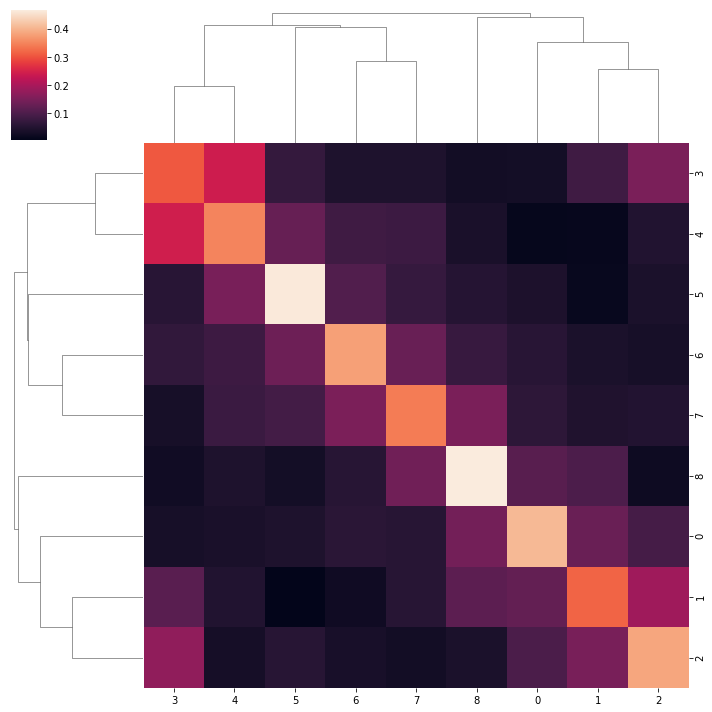

In [29]:
gnn_heatmap = np.array([
    np.mean(
        mts.genealogical_nearest_neighbours(
            mts.samples(i),
            [mts.samples(j) for j in range(num_demes)]),
        axis=0,
    )
    for i in range(num_demes)
])

sns.clustermap(gnn_heatmap);

NB: should note here that the dendrogram to the side can be misleading, e.g. in this case it isn't a tree because the populations are on a torus.

## Some relevant papers and resources
 -  [Efficient coalescent simulation and genealogical analysis for large sample sizes](https://doi.org/10.1371/journal.pcbi.1004842)
 - [Efficient ancestry and mutation simulation with msprime 1.0](https://doi.org/10.1093/genetics/iyab229)
 - [tskit.dev documentation](https://tskit.dev/)

## Acknowledgement
This workbook is heavily based on [Georgia Tsambos' Jupyter notebooks](https://github.com/gtsambos/2022-ts-workshops).